# LioNets: Turbofan Engine Degradation Simulation Dataset with Neural Networks -> Classification Task

In this notebook, we present how LioNets can be applied in predictive models using time series data.

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
%matplotlib inline
from IPython.display import Image
from IPython.display import SVG
from IPython.display import display                               
from ipywidgets import interactive, BoundedFloatText, FloatSlider, IntSlider, ToggleButtons,  \
    RadioButtons, IntRangeSlider, Dropdown, jslink, jsdlink, interactive_output, HBox, VBox, Label
from load_dataset import Load_Dataset
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import numpy as np
import random
import re
from math import sqrt, exp, log
from sklearn.linear_model import Lasso, Ridge, RidgeCV, SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, balanced_accuracy_score, accuracy_score
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, TimeDistributed, RepeatVector,Flatten, \
    Input, Dropout, LSTM, concatenate, Reshape, Conv1D, GlobalMaxPool1D
import keras.backend as K
from keras.utils import plot_model
from LioNets import LioNet
from nbeats_keras.model import NBeatsNet
from Interpretable_PCA import iPCA

Using TensorFlow backend.


First of all, we load and clean our data.

In [3]:
fm, feature_names = Load_Dataset.load_data_turbofan(False)

fm1_train = fm['FaultMode1']['df_train']
fm1_train_target = fm1_train['RUL'].values
fm1_test= fm['FaultMode1']['df_test']
fm1_test_target = fm1_test['RUL'].values

We are dropping some unecessary features.

In [4]:
LSTM_train = fm1_train.drop(columns=['t', 'os_1', 'os_2', 'os_3', 's_01', 's_05', 's_06', 's_10', 's_16', 's_18', 's_19', 's_22', 's_23', 's_24', 's_25', 's_26'])
LSTM_test = fm1_test.drop(columns=['t', 'os_1', 'os_2', 'os_3', 's_01', 's_05', 's_06', 's_10', 's_16', 's_18', 's_19', 's_22', 's_23', 's_24', 's_25', 's_26'])

We collect the different units, in order to the next steps to create time windows

In [5]:
train_units = set(LSTM_train['u'].values)
test_units = set(LSTM_test['u'].values)

We are scaling our data per feature

In [6]:
sensors = ['s_02', 's_03', 's_04', 's_07', 's_08', 's_09', 's_11', 's_12',
            's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
scalers = {}
for column in sensors:
    scaler = MinMaxScaler(feature_range=(0.1,1.1))
    LSTM_train[column] = scaler.fit_transform(LSTM_train[column].values.reshape(-1,1))
    LSTM_test[column] = scaler.transform(LSTM_test[column].values.reshape(-1,1))
    scalers[column] = scaler

We create time windows with a specific size. In this example, we create time windows of 50 timesteps.

In [7]:
unit_scalers = {}
window = 50
temp_LSTM_x_train = []
LSTM_y_train = []
for unit in train_units:
    temp_unit = LSTM_train[LSTM_train['u']==unit].drop(columns=['u','RUL']).values
    temp_unit_RUL = LSTM_train[LSTM_train['u']==unit]['RUL'].values
    
    for i in range(len(temp_unit) - window + 1):#elekse edw an len temp_unit - window > 0
        temp_instance = []
        for j in range(window):
            temp_instance.append(temp_unit[i+j])
        temp_LSTM_x_train.append(np.array(temp_instance))
        LSTM_y_train.append(temp_unit_RUL[i+window-1])
LSTM_y_train = np.array(LSTM_y_train)
LSTM_x_train = np.array(temp_LSTM_x_train)

temp_LSTM_x_test = []
LSTM_y_test = []
for unit in test_units:
    temp_unit = LSTM_test[LSTM_test['u']==unit].drop(columns=['u','RUL']).values
    temp_unit_RUL = LSTM_test[LSTM_test['u']==unit]['RUL'].values
        
    for i in range(len(temp_unit) - window + 1):#elekse edw an len temp_unit - window > 0
        temp_instance = []
        for j in range(window):
            temp_instance.append(temp_unit[i+j])
        temp_LSTM_x_test.append(np.array(temp_instance))
        LSTM_y_test.append(temp_unit_RUL[i+window-1])
LSTM_y_test = np.array(LSTM_y_test)
LSTM_x_test = np.array(temp_LSTM_x_test)

We can check how many train, test instances we have. These are changing regarding the time window size.

In [8]:
LSTM_x_train.shape, LSTM_x_test.shape, LSTM_y_train.shape, LSTM_y_test.shape

((15731, 50, 14), (8255, 50, 14), (15731,), (8255,))

Now we need to transform our RUL to binary classes. 0 Would mean that no maintenance is needed, because the prediction had a high RUL value. 1 would mean that the RUL is low and you may need maintenance on your component! You can try different time frames as well.

In [9]:
time_frame = 30

In [10]:
temp_LSTM_y_train = np.array([1 if i <= time_frame else 0 for i in LSTM_y_train])
temp_LSTM_y_test = np.array([1 if i <= time_frame else 0 for i in LSTM_y_test])

We need a rmse loss function too! for the decoder

In [11]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Now, we can build our predictor

In [12]:
feature_names = fm1_train.columns
encoder_input = Input(shape=(LSTM_x_train[0].shape))

encoder_x = LSTM(units=80, return_sequences=True, activation='tanh')(encoder_input)
encoder_x = Dropout(0.5)(encoder_x)
encoder_x = LSTM(units=40, return_sequences=False, activation='tanh')(encoder_x)

encoder_y = Conv1D(filters=40,kernel_size=3,activation='tanh')(encoder_input)
encoder_y = GlobalMaxPool1D()(encoder_y)

encoded = concatenate([encoder_x,encoder_y])
encoded = Dropout(0.5)(encoded)
encoded = Dense(80, activation='tanh')(encoded)#Relu and selu
encoded = Dropout(0.5)(encoded)
encoded = Dense(40, activation='tanh')(encoded)#Relu and selu
predictions = Dense(1, activation='sigmoid')(encoded)#Relu and selu
predictor = Model(encoder_input,predictions)

predictor.compile(optimizer="adam",loss=['binary_crossentropy'],metrics=['accuracy'])
#print(predictor.summary())

checkpoint_name = 'TEDS_Predictor_Classification.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Then, we train the predictor.

In [13]:
#predictor.fit(LSTM_x_train, temp_LSTM_y_train, epochs=250, batch_size=512, shuffle=True, validation_split=0.33, verbose=2, callbacks=[checkpoint])

We load our weights, and we measure the performance.

In [14]:
wights_file = 'TEDS_Predictor_Classification.hdf5' # choose the best checkpoint few features
predictor.load_weights(wights_file) # load it
predictor.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])

In [15]:
temp_pred = predictor.predict(LSTM_x_train)

In [16]:
temp_pred = predictor.predict(LSTM_x_train)
predictions = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Train:',f1_score(temp_LSTM_y_train,predictions, average='micro'),f1_score(temp_LSTM_y_train,predictions, average='weighted'),balanced_accuracy_score(temp_LSTM_y_train,predictions),accuracy_score(temp_LSTM_y_train,predictions))

temp_pred = predictor.predict(LSTM_x_test)
predictions = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Test:',f1_score(temp_LSTM_y_test,predictions, average='micro'),f1_score(temp_LSTM_y_test,predictions, average='weighted'),balanced_accuracy_score(temp_LSTM_y_test,predictions),accuracy_score(temp_LSTM_y_test,predictions))

Train: 0.9758438751509758 0.9756563803680429 0.9542879398101445 0.9758438751509758
Test: 0.9855844942459115 0.9845923721401666 0.8467556329064839 0.9855844942459115


Then, we have to extract the encoder from our predictor.

In [17]:
encoder = Model(input=predictor.input, output=[predictor.layers[-2].output])
encoder.trainable = False
encoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])
#encoder.summary()

Now we are ready to extract for all instances, their encoded representation

In [18]:
encoded_LSTM_x_train = encoder.predict(LSTM_x_train)
encoded_LSTM_x_test = encoder.predict(LSTM_x_test)

And by that, we build the decoder.

In [19]:
encoded_input = Input(shape=(encoded_LSTM_x_train[0].shape))
decoded = Dense(120, activation='tanh')(encoded_input)
decoded = Dropout(0.5)(decoded)

decoded_y = RepeatVector(54)(decoded)
decoded_y = Conv1D(filters=50,kernel_size=5,activation='tanh')(decoded_y)

decoded_x = RepeatVector(50)(decoded)
decoded_x = LSTM(units=80, return_sequences=True, activation='tanh')(decoded_x)
decoded_x = Dropout(0.5)(decoded_x)
decoded_x = LSTM(units=50, return_sequences=True, activation='tanh')(decoded_x)

decoded = concatenate([decoded_x,decoded_y])
decoded = Dense(50, activation='sigmoid')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(14, activation='sigmoid')(decoded)

decoder = Model(encoded_input,decoded)

decoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])
#print(decoder.summary())

checkpoint_name = 'TEDS_Decoder_Classification.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

In [20]:
#decoder.fit(encoded_LSTM_x_train, LSTM_x_train, epochs=250, batch_size=512, shuffle=True, validation_split=0.33, verbose=2, callbacks=[checkpoint])

In [21]:
wights_file = 'TEDS_Decoder_Classification.hdf5' # choose the best checkpoint few features
decoder.load_weights(wights_file) # load it
decoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])

In [22]:
decoder.evaluate(encoded_LSTM_x_train,LSTM_x_train)

15731/15731 [==============================] - 7s 454us/step


[0.06820674527842154, 0.052121663511208616, 0.004656450242404678]

In [23]:
decoder.evaluate(encoded_LSTM_x_test,LSTM_x_test)

8255/8255 [==============================] - 3s 421us/step


[0.06830550037067201, 0.052297253303820984, 0.0046694804948705535]

---
## Forecaster

In [24]:
window = 50
forecast_timesteps = 5

temp_fc_x_train = []
temp_fc_y_train = []
for unit in train_units:
    temp_unit = LSTM_train[LSTM_train['u']==unit].drop(columns=['u','RUL']).values
   
    for i in range(len(temp_unit) - window - forecast_timesteps + 1):#elekse edw an len temp_unit - window > 0
        temp_instance_x = []
        temp_instance_y = []
        for j in range(window):
            temp_instance_x.append(temp_unit[i+j])
        for z in range(forecast_timesteps):
            temp_instance_y.append(temp_unit[i+j+z+1])            
        temp_fc_x_train.append(np.array(temp_instance_x))
        temp_fc_y_train.append(np.array(temp_instance_y))       
fc_x_train = np.array(temp_fc_x_train)
fc_y_train = np.array(temp_fc_y_train)

temp_fc_x_test = []
temp_fc_y_test = []
for unit in test_units:
    temp_unit = LSTM_test[LSTM_test['u']==unit].drop(columns=['u','RUL']).values
        
    for i in range(len(temp_unit) - window - forecast_timesteps + 1):#elekse edw an len temp_unit - window > 0
        temp_instance_x = []
        temp_instance_y = []
        for j in range(window):
            temp_instance_x.append(temp_unit[i+j])
        for z in range(forecast_timesteps):
            temp_instance_y.append(temp_unit[i+j+z+1])            
        temp_fc_x_test.append(np.array(temp_instance_x))
        temp_fc_y_test.append(np.array(temp_instance_y))       
fc_x_test = np.array(temp_fc_x_test)
fc_y_test = np.array(temp_fc_y_test)

In [25]:
fc_x_train.shape, fc_x_test.shape, fc_y_train.shape, fc_y_test.shape

((15231, 50, 14), (7794, 50, 14), (15231, 5, 14), (7794, 5, 14))

In [26]:
forecast_input = Input(shape=(LSTM_x_train[0].shape))

forecast_x = LSTM(units=120, return_sequences=True, activation='tanh')(forecast_input)
forecast_x = Dropout(0.7)(forecast_x)
forecast_x = LSTM(units=50, return_sequences=True, activation='tanh')(forecast_x)
forecast_x = Conv1D(filters=50,kernel_size=46,activation='tanh')(forecast_x)

forecast_y = Conv1D(filters=50,kernel_size=46,activation='tanh')(forecast_input)

forecast = concatenate([forecast_y,forecast_x])
forecast = Dropout(0.7)(forecast)
forecast = LSTM(40, return_sequences=True, activation='relu')(forecast)#Relu and selu
forecast = Dropout(0.7)(forecast)
predictions = LSTM(14, return_sequences=True, activation='linear')(forecast)#Relu and selu
forecaster = Model(forecast_input,predictions)
forecaster.summary()
forecaster.compile(optimizer="adam", loss=[root_mean_squared_error],metrics=['mae','mse'])

checkpoint_name = 'TEDS_Forecaster_Classification_Matrix.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50, 14)       0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 50, 120)      64800       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 50, 120)      0           lstm_5[0][0]                     
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 50, 50)       34200       dropout_7[0][0]                  
__________________________________________________________________________________________________
conv1d_4 (

In [27]:
#forecaster.fit(fc_x_train, fc_y_train, epochs=250, batch_size=512, shuffle=True, validation_split=0.3, verbose=2, callbacks=[checkpoint])

In [28]:
weights_file = 'TEDS_Forecaster_Classification_Matrix.hdf5' # choose the best checkpoint few features
forecaster.load_weights(weights_file) # load it
forecaster.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])

In [29]:
# predictions = forecaster.predict(fc_x_train)
# print('Train:',mean_absolute_error(fc_y_train.reshape(-1,70),predictions.reshape(-1,70)),mean_squared_error(fc_y_train.reshape(-1,70),predictions.reshape(-1,70)),sqrt(mean_squared_error(fc_y_train.reshape(-1,70),predictions.reshape(-1,70))))
# print(r2_score(fc_y_train.reshape(-1,70),predictions.reshape(-1,70)))

In [30]:
# predictions = forecaster.predict(fc_x_test)
# print('Test:',mean_absolute_error(fc_y_test.reshape(-1,70),predictions.reshape(-1,70)),mean_squared_error(fc_y_test.reshape(-1,70),predictions.reshape(-1,70)),sqrt(mean_squared_error(fc_y_test.reshape(-1,70),predictions.reshape(-1,70))))
# print(r2_score(fc_y_test.reshape(-1,70),predictions.reshape(-1,70)))

---
## N-Beats

In [31]:
# Definition of the model.
nbeats = NBeatsNet(input_dim = 14, backcast_length=50, forecast_length=5,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), 
                  nb_blocks_per_stack=2,
                  thetas_dim=(4, 4), 
                  share_weights_in_stack=True, 
                  hidden_layer_units=64)

# Definition of the objective function and the optimizer.
nbeats.compile_model(loss='mae', learning_rate=1e-6)
 
# Train the model.
#nbeats.fit(fc_x_train, fc_y_train, verbose=1, validation_split=0.3, epochs=100, batch_size=128)

# Save the model for later.
#nbeats.save('n_beats_model.h5')

# # Load the model.
nbeats = NBeatsNet.load('n_beats_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 50, 14)       0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 50)           0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 64)           3264        lambda[0][0]                     
                                                                 lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
                                                                 lambda_3[0][0]                   
          

Instructions for updating:
Use tf.cast instead.


In [32]:
# predictions = nbeats.predict(fc_x_train)
# print('Train:',mean_absolute_error(fc_y_train.reshape(-1,70),predictions.reshape(-1,70)),mean_squared_error(fc_y_train.reshape(-1,70),predictions.reshape(-1,70)),sqrt(mean_squared_error(fc_y_train.reshape(-1,70),predictions.reshape(-1,70))))
# print(r2_score(fc_y_train.reshape(-1,70),predictions.reshape(-1,70)))

In [33]:
# predictions = nbeats.predict(fc_x_test)
# print('Test:',mean_absolute_error(fc_y_test.reshape(-1,70),predictions.reshape(-1,70)),mean_squared_error(fc_y_test.reshape(-1,70),predictions.reshape(-1,70)),sqrt(mean_squared_error(fc_y_test.reshape(-1,70),predictions.reshape(-1,70))))
# print(r2_score(fc_y_test.reshape(-1,70),predictions.reshape(-1,70)))

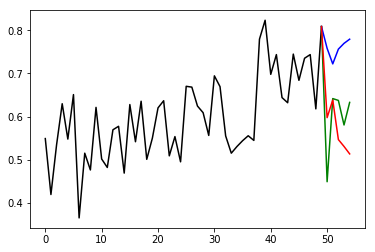

In [34]:
sens = 10
j = 123
temp_instance = fc_x_train[j].copy()[np.newaxis]
nbts = nbeats.predict(temp_instance)
pred = forecaster.predict(temp_instance)
ln = temp_instance.shape[1]
plt.plot(np.arange(ln), temp_instance.squeeze()[:,sens], color='black')
plt.plot(np.arange(ln-1,ln+5), np.append(temp_instance.squeeze()[-1:,sens],fc_y_test[j][:,sens]), color='g') # Ground Truth
plt.plot(np.arange(ln-1,ln+5), np.append(temp_instance.squeeze()[-1:,sens],pred.squeeze()[:,sens]), color='b') # Neural Forecast 
plt.plot(np.arange(ln-1,ln+5), np.append(temp_instance.squeeze()[-1:,sens],nbts.squeeze()[:,sens]), color='r') # NBeats

---
## XYZ7 Model

In [35]:
window = 50
forecast_steps = 5

rul_train, xyz7_x_train, xyz7_y_train, rul_temp = [],[],[],[]
for unit in train_units:
    temp_unit = LSTM_train[LSTM_train['u']==unit].drop(columns=['u','RUL']).values   
    for i in range(len(temp_unit) - window + 1): # elekse edw an len temp_unit - window > 0
        temp_instance = np.array(temp_unit[i:i+window])
        rul_temp.append(temp_instance)
        xyz7_x_train.append(temp_instance[:-forecast_steps])
        xyz7_y_train.append(temp_instance[-forecast_steps:])

rul_train = predictor.predict(np.array(rul_temp))
xyz7_x_train = np.array(xyz7_x_train)
xyz7_y_train = np.array(xyz7_y_train)

rul_test, xyz7_x_test, xyz7_y_test, rul_temp = [],[],[],[]
for unit in test_units:
    temp_unit = LSTM_test[LSTM_test['u']==unit].drop(columns=['u','RUL']).values   
    for i in range(len(temp_unit) - window + 1): # elekse edw an len temp_unit - window > 0
        temp_instance = np.array(temp_unit[i:i+window])
        rul_temp.append(temp_instance)
        xyz7_x_test.append(temp_instance[:-forecast_steps])
        xyz7_y_test.append(temp_instance[-forecast_steps:])

rul_test = predictor.predict(np.array(rul_temp))
xyz7_x_test = np.array(xyz7_x_test)
xyz7_y_test = np.array(xyz7_y_test)

In [36]:
rul_train.shape , xyz7_x_train.shape , xyz7_y_train.shape 

((15731, 1), (15731, 45, 14), (15731, 5, 14))

In [43]:
forecast_input = Input(shape=(xyz7_x_train[0].shape))
rul_input = Input(shape = (rul_train[0].shape))
rul = RepeatVector(5)(rul_input)

forecast_x = LSTM(units=120, return_sequences=True, activation='tanh')(forecast_input)
forecast_x = Dropout(0.7)(forecast_x)
forecast_x = LSTM(units=50, return_sequences=True, activation='tanh')(forecast_x)
forecast_x = Conv1D(filters=50,kernel_size=41,activation='tanh')(forecast_x)
forecast_x = concatenate([forecast_x, rul])


forecast_y = Conv1D(filters=50,kernel_size=41,activation='tanh')(forecast_input)
forecast_y = concatenate([forecast_y, rul])


forecast = concatenate([forecast_y, forecast_x, rul])
forecast = Dropout(0.7)(forecast)
forecast = LSTM(40, return_sequences=True, activation='relu')(forecast)#Relu and selu
forecast = concatenate([forecast, rul])
forecast = Dropout(0.7)(forecast)
predictions = LSTM(14, return_sequences=True, activation='linear')(forecast)#Relu and selu

xyz7_model = Model([forecast_input, rul_input],predictions)
opt = keras.optimizers.Adam(lr=0.001)
xyz7_model.compile(optimizer=opt, loss=[root_mean_squared_error],metrics=['mae','mse'])

checkpoint_name = 'TEDS_XYZ7_Classification.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

In [45]:
xyz7_model.fit([xyz7_x_train,rul_train], xyz7_y_train, epochs=250, batch_size=512, shuffle=True, validation_split=0.3, verbose=2, callbacks=[checkpoint])

Train on 11011 samples, validate on 4720 samples
Epoch 1/250
 - 13s - loss: 0.4664 - mean_absolute_error: 0.4093 - mean_squared_error: 0.2193 - val_loss: 0.3689 - val_mean_absolute_error: 0.3084 - val_mean_squared_error: 0.1361

Epoch 00001: val_loss improved from inf to 0.36893, saving model to TEDS_XYZ7_Classification.hdf5
Epoch 2/250
 - 8s - loss: 0.3759 - mean_absolute_error: 0.3154 - mean_squared_error: 0.1418 - val_loss: 0.2719 - val_mean_absolute_error: 0.2134 - val_mean_squared_error: 0.0739

Epoch 00002: val_loss improved from 0.36893 to 0.27186, saving model to TEDS_XYZ7_Classification.hdf5
Epoch 3/250
 - 8s - loss: 0.3047 - mean_absolute_error: 0.2447 - mean_squared_error: 0.0932 - val_loss: 0.1932 - val_mean_absolute_error: 0.1447 - val_mean_squared_error: 0.0374

Epoch 00003: val_loss improved from 0.27186 to 0.19321, saving model to TEDS_XYZ7_Classification.hdf5
Epoch 4/250
 - 8s - loss: 0.2490 - mean_absolute_error: 0.1921 - mean_squared_error: 0.0622 - val_loss: 0.1567 


Epoch 00031: val_loss improved from 0.07316 to 0.07279, saving model to TEDS_XYZ7_Classification.hdf5
Epoch 32/250
 - 8s - loss: 0.0869 - mean_absolute_error: 0.0658 - mean_squared_error: 0.0075 - val_loss: 0.0737 - val_mean_absolute_error: 0.0565 - val_mean_squared_error: 0.0054

Epoch 00032: val_loss did not improve from 0.07279
Epoch 33/250
 - 8s - loss: 0.0868 - mean_absolute_error: 0.0658 - mean_squared_error: 0.0075 - val_loss: 0.0738 - val_mean_absolute_error: 0.0566 - val_mean_squared_error: 0.0055

Epoch 00033: val_loss did not improve from 0.07279
Epoch 34/250
 - 9s - loss: 0.0861 - mean_absolute_error: 0.0652 - mean_squared_error: 0.0074 - val_loss: 0.0736 - val_mean_absolute_error: 0.0566 - val_mean_squared_error: 0.0054

Epoch 00034: val_loss did not improve from 0.07279
Epoch 35/250
 - 8s - loss: 0.0853 - mean_absolute_error: 0.0648 - mean_squared_error: 0.0073 - val_loss: 0.0735 - val_mean_absolute_error: 0.0565 - val_mean_squared_error: 0.0054

Epoch 00035: val_loss di


Epoch 00065: val_loss did not improve from 0.07128
Epoch 66/250
 - 8s - loss: 0.0801 - mean_absolute_error: 0.0610 - mean_squared_error: 0.0064 - val_loss: 0.0713 - val_mean_absolute_error: 0.0545 - val_mean_squared_error: 0.0051

Epoch 00066: val_loss did not improve from 0.07128
Epoch 67/250
 - 9s - loss: 0.0796 - mean_absolute_error: 0.0607 - mean_squared_error: 0.0063 - val_loss: 0.0712 - val_mean_absolute_error: 0.0546 - val_mean_squared_error: 0.0051

Epoch 00067: val_loss improved from 0.07128 to 0.07119, saving model to TEDS_XYZ7_Classification.hdf5
Epoch 68/250
 - 8s - loss: 0.0798 - mean_absolute_error: 0.0608 - mean_squared_error: 0.0064 - val_loss: 0.0716 - val_mean_absolute_error: 0.0547 - val_mean_squared_error: 0.0051

Epoch 00068: val_loss did not improve from 0.07119
Epoch 69/250
 - 8s - loss: 0.0797 - mean_absolute_error: 0.0606 - mean_squared_error: 0.0063 - val_loss: 0.0717 - val_mean_absolute_error: 0.0548 - val_mean_squared_error: 0.0051

Epoch 00069: val_loss di


Epoch 00099: val_loss did not improve from 0.07055
Epoch 100/250
 - 8s - loss: 0.0780 - mean_absolute_error: 0.0595 - mean_squared_error: 0.0061 - val_loss: 0.0709 - val_mean_absolute_error: 0.0543 - val_mean_squared_error: 0.0050

Epoch 00100: val_loss did not improve from 0.07055
Epoch 101/250
 - 8s - loss: 0.0783 - mean_absolute_error: 0.0596 - mean_squared_error: 0.0061 - val_loss: 0.0706 - val_mean_absolute_error: 0.0538 - val_mean_squared_error: 0.0050

Epoch 00101: val_loss did not improve from 0.07055
Epoch 102/250
 - 8s - loss: 0.0780 - mean_absolute_error: 0.0594 - mean_squared_error: 0.0061 - val_loss: 0.0706 - val_mean_absolute_error: 0.0539 - val_mean_squared_error: 0.0050

Epoch 00102: val_loss did not improve from 0.07055
Epoch 103/250
 - 8s - loss: 0.0784 - mean_absolute_error: 0.0596 - mean_squared_error: 0.0062 - val_loss: 0.0712 - val_mean_absolute_error: 0.0543 - val_mean_squared_error: 0.0051

Epoch 00103: val_loss did not improve from 0.07055
Epoch 104/250
 - 8s 


Epoch 00134: val_loss did not improve from 0.07021
Epoch 135/250
 - 10s - loss: 0.0768 - mean_absolute_error: 0.0585 - mean_squared_error: 0.0059 - val_loss: 0.0702 - val_mean_absolute_error: 0.0535 - val_mean_squared_error: 0.0049

Epoch 00135: val_loss improved from 0.07021 to 0.07016, saving model to TEDS_XYZ7_Classification.hdf5
Epoch 136/250
 - 9s - loss: 0.0770 - mean_absolute_error: 0.0587 - mean_squared_error: 0.0059 - val_loss: 0.0702 - val_mean_absolute_error: 0.0536 - val_mean_squared_error: 0.0049

Epoch 00136: val_loss did not improve from 0.07016
Epoch 137/250
 - 8s - loss: 0.0769 - mean_absolute_error: 0.0586 - mean_squared_error: 0.0059 - val_loss: 0.0702 - val_mean_absolute_error: 0.0536 - val_mean_squared_error: 0.0049

Epoch 00137: val_loss did not improve from 0.07016
Epoch 138/250
 - 8s - loss: 0.0767 - mean_absolute_error: 0.0585 - mean_squared_error: 0.0059 - val_loss: 0.0702 - val_mean_absolute_error: 0.0535 - val_mean_squared_error: 0.0049

Epoch 00138: val_lo

 - 9s - loss: 0.0760 - mean_absolute_error: 0.0579 - mean_squared_error: 0.0058 - val_loss: 0.0701 - val_mean_absolute_error: 0.0535 - val_mean_squared_error: 0.0049

Epoch 00169: val_loss did not improve from 0.06987
Epoch 170/250
 - 8s - loss: 0.0763 - mean_absolute_error: 0.0581 - mean_squared_error: 0.0058 - val_loss: 0.0703 - val_mean_absolute_error: 0.0535 - val_mean_squared_error: 0.0049

Epoch 00170: val_loss did not improve from 0.06987
Epoch 171/250
 - 8s - loss: 0.0762 - mean_absolute_error: 0.0581 - mean_squared_error: 0.0058 - val_loss: 0.0700 - val_mean_absolute_error: 0.0533 - val_mean_squared_error: 0.0049

Epoch 00171: val_loss did not improve from 0.06987
Epoch 172/250
 - 8s - loss: 0.0760 - mean_absolute_error: 0.0579 - mean_squared_error: 0.0058 - val_loss: 0.0703 - val_mean_absolute_error: 0.0535 - val_mean_squared_error: 0.0049

Epoch 00172: val_loss did not improve from 0.06987
Epoch 173/250
 - 8s - loss: 0.0762 - mean_absolute_error: 0.0581 - mean_squared_error:


Epoch 00203: val_loss did not improve from 0.06969
Epoch 204/250
 - 8s - loss: 0.0754 - mean_absolute_error: 0.0574 - mean_squared_error: 0.0057 - val_loss: 0.0697 - val_mean_absolute_error: 0.0530 - val_mean_squared_error: 0.0049

Epoch 00204: val_loss improved from 0.06969 to 0.06968, saving model to TEDS_XYZ7_Classification.hdf5
Epoch 205/250
 - 8s - loss: 0.0753 - mean_absolute_error: 0.0574 - mean_squared_error: 0.0057 - val_loss: 0.0698 - val_mean_absolute_error: 0.0531 - val_mean_squared_error: 0.0049

Epoch 00205: val_loss did not improve from 0.06968
Epoch 206/250
 - 8s - loss: 0.0754 - mean_absolute_error: 0.0575 - mean_squared_error: 0.0057 - val_loss: 0.0699 - val_mean_absolute_error: 0.0532 - val_mean_squared_error: 0.0049

Epoch 00206: val_loss did not improve from 0.06968
Epoch 207/250
 - 8s - loss: 0.0753 - mean_absolute_error: 0.0574 - mean_squared_error: 0.0057 - val_loss: 0.0700 - val_mean_absolute_error: 0.0534 - val_mean_squared_error: 0.0049

Epoch 00207: val_los


Epoch 00238: val_loss improved from 0.06949 to 0.06948, saving model to TEDS_XYZ7_Classification.hdf5
Epoch 239/250
 - 8s - loss: 0.0745 - mean_absolute_error: 0.0569 - mean_squared_error: 0.0056 - val_loss: 0.0696 - val_mean_absolute_error: 0.0529 - val_mean_squared_error: 0.0048

Epoch 00239: val_loss did not improve from 0.06948
Epoch 240/250
 - 8s - loss: 0.0745 - mean_absolute_error: 0.0568 - mean_squared_error: 0.0055 - val_loss: 0.0697 - val_mean_absolute_error: 0.0532 - val_mean_squared_error: 0.0049

Epoch 00240: val_loss did not improve from 0.06948
Epoch 241/250
 - 9s - loss: 0.0744 - mean_absolute_error: 0.0568 - mean_squared_error: 0.0055 - val_loss: 0.0697 - val_mean_absolute_error: 0.0530 - val_mean_squared_error: 0.0049

Epoch 00241: val_loss did not improve from 0.06948
Epoch 242/250
 - 8s - loss: 0.0744 - mean_absolute_error: 0.0568 - mean_squared_error: 0.0055 - val_loss: 0.0695 - val_mean_absolute_error: 0.0528 - val_mean_squared_error: 0.0048

Epoch 00242: val_los

In [56]:
xyz7_model.predict([xyz7_x_test,rul_testo])

array([[[0.5838661 , 0.5548849 , 0.5961297 , ..., 0.569064  ,
         0.627631  , 0.65402776],
        [0.56520945, 0.5337567 , 0.56853396, ..., 0.53899753,
         0.5855118 , 0.6065012 ],
        [0.5785205 , 0.54647356, 0.586834  , ..., 0.55750877,
         0.60265386, 0.6246188 ],
        [0.5756649 , 0.5450725 , 0.5851538 , ..., 0.55424714,
         0.59887654, 0.6206935 ],
        [0.5777748 , 0.54951966, 0.5892423 , ..., 0.55706185,
         0.59597737, 0.6175666 ]],

       [[0.5703037 , 0.54357857, 0.5810123 , ..., 0.55693924,
         0.63664216, 0.66438854],
        [0.54990155, 0.5196589 , 0.5524226 , ..., 0.52674896,
         0.5992856 , 0.6208492 ],
        [0.55769557, 0.5304658 , 0.5644543 , ..., 0.540351  ,
         0.62083274, 0.64388525],
        [0.55389595, 0.5285437 , 0.562146  , ..., 0.5358039 ,
         0.617737  , 0.6413391 ],
        [0.552556  , 0.52979547, 0.56223464, ..., 0.53553   ,
         0.6162312 , 0.6396193 ]],

       [[0.5723115 , 0.54515934, 0.5

---
## LioNets & Interpretable PCA Experiments 
Having everything setted up, we are now ready to try our methodology. We first initialize LioNets. LioNets requires a predictor (the classifier itself), an encoder (extracted from the predictor), a decoder, as well as some data (for best results the training data, in order to push the neighbourhood generation through known distribution for the network). 

We also test the intrepretable capabilities of PCA. Using the LioNet from above we generate a neighbourhood around a test instance and then apply per-sensor PCA reducing the sensor readings dimensionality from 50 (timesteps) to 1. Then we fit the transformed data with their predictions to a Rigde Regression model to acquire the weights(importance) of each sensor. 

In [57]:
lionet = LioNet(predictor, decoder, encoder, LSTM_x_train)
ipca = iPCA(lionet.give_me_the_neighbourhood, 2000, 'local')

Then we would like to manually evaluate an instance

In [58]:
temp_instance = LSTM_x_train[112].copy()

LioNets weights

In [59]:
model = Ridge(alpha=0.0001,fit_intercept=True,random_state=0)
lionet_weights, real_prediction, local_prediction = lionet.explain_instance(temp_instance,200,model)

Interpretable PCA weights

In [60]:
pca_sensor_weights, pca_timestep_weights = ipca.find_importance(temp_instance)
pca_timestep_weights = pca_timestep_weights.reshape(700)

In [61]:
weights_dict = {'LioNets':lionet_weights,'Interpretable PCA':pca_timestep_weights}

Data statistics -> (Global Mean & STD per sensor) 

In [62]:
temp_train = LSTM_x_train.reshape(-1,14)
global_mean, global_std = [],[]
for i in range(14):
    global_mean.append(temp_train[:,i].mean())
    global_std.append(temp_train[:,i].std())

Make modifications to the measurements of a seleced sensor.

In [63]:
def modify(temp_instance, weights, sens, mod, uni_sldr=0, rd_btn=1, rng_sldr=(1,50)):
    
    start, end = rng_sldr[0], rng_sldr[1]
    
    mod_instance = temp_instance.copy()
    local_mean = temp_instance[start-1:end,sens].mean()
      
    # ---MODS---        
    if mod == 1: # Uniform
        for i in range(start-1, end):
            if weights.reshape(50,14)[i,sens] > 0 and rd_btn > 0:
                mod_instance[i,sens] = mod_instance[i,sens] + uni_sldr
            if weights.reshape(50,14)[i,sens] < 0 and rd_btn < 0:
                mod_instance[i,sens] = mod_instance[i,sens] + uni_sldr    
    elif mod == 2: # Local MEan
        mod_instance[start-1:end, sens] = local_mean    
    elif mod == 3: # Global Mean 
        mod_instance[start-1:end, sens] = global_mean[sens]   
    elif mod == 4: # Zeros
        mod_instance[start-1:end, sens] = 0.1    
    elif mod == 5: # Gaussian Noise
        for i in range(start-1, end):
            np.random.seed(2000+i)
            gaussian_noise = np.random.normal(global_mean[sens], global_std[sens], 1)/10
            mod_instance[i,sens] += gaussian_noise[0]
        np.clip(mod_instance,0.1,1.1,out=mod_instance)    
    elif mod == 6: # Neural Forecaster
        prediction = forecaster.predict(np.expand_dims(temp_instance,axis=0))
        prediction = prediction.squeeze()
        mod_instance = np.append(temp_instance,prediction,axis=0)
        mod_instance = mod_instance[5:]
    elif mod == 7: # Static Forecaster
        for i in range(mod_instance.shape[1]):
            dif = mod_instance[-1,i] - mod_instance[-6:-1,i]
            temp = np.flip(dif) + mod_instance[-1,i]
            #temp = np.array([dif*(e+1) for e,i in enumerate(range(5))]) + mod_instance[-1,i]
            mod_instance[:,i] = np.append(mod_instance[5:,i],temp)  
            np.clip(mod_instance[:,i],0.1,1.1,out=mod_instance[:,i])
    elif mod == 8: # NBeats Forecaster
        prediction = nbeats.predict(np.expand_dims(temp_instance,axis=0))
        prediction = prediction.squeeze()
        mod_instance = np.append(temp_instance,prediction,axis=0)
        mod_instance = mod_instance[5:]
        
    return mod_instance

In [64]:
def moded_instance_statistics(instance, interpret_method):
    
    #model = Ridge(alpha=0.0001,fit_intercept=True,random_state=0)
    #weights, real_prediction, local_prediction = lionet.explain_instance(instance,200,model)
    #weights = weights * instance.reshape(700)
    if interpret_method == 'Interpretable PCA':
        _, weights = ipca.find_importance(instance)
        weights = weights.reshape(700)
        print("It crashes here: moded_instance_statistics in the first if else. You need to define real prediction using your model\
              and you also need to define the local prediction. You need this information through PCA so you should change the code there!!!!")
        #!You should calculate here the realPred and the localPred by InterpretablePCA
    else:
        model = Ridge(alpha=0.0001,fit_intercept=True,random_state=0)
        weights, real_prediction, local_prediction = lionet.explain_instance(instance,200,model)
        weights = weights * instance.reshape(700)
    sensors_all = {}
    count = 0
    for j in range(50):
        count2 = 0
        for i in sensors:
            sensors_all.setdefault(i,[]).append([j, weights[count+count2], instance[j][count2],
                                                 weights[count+count2]*instance[j][count2]])
            count2 = count2 + 1
        count = count + 14
        
    sensors_std = []
    sensors_mean = []
    sensors_max = []
    sensors_min = []
    for i in sensors_all:
        naa = np.array(sensors_all[i])[:,3]
        sensors_std.append(naa.std())
        sensors_mean.append(naa.mean())
        sensors_max.append(naa.max())
        sensors_min.append(naa.min())
        
    return [real_prediction, local_prediction], sensors_all, [sensors_mean,sensors_std,sensors_min,sensors_max]

Find 2 sensors with the most negative and positive influence based on the mean of time-step feature weights.

Then recommend certain modifications that can be applied on their measurements that lead to a change in the RUL propability estimation.

In [65]:
def recommend_modifications(instance, weights, interpret_method):
    
    _, _, original_sens_stats = moded_instance_statistics(instance,interpret_method)
    sensors_mean =  original_sens_stats[0]
    indexed = list(enumerate(sensors_mean))
    indexed.sort(key=lambda tup: tup[1])
    cls0_sens = list([i for i, v in indexed[:2]])
    cls1_sens = list(reversed([i for i, v in indexed[-2:]]))
#     print("Class 0 important sensors:",sensors[cls0_sens[0]], sensors[cls0_sens[1]])
#     print("Class 1 important sensors:",sensors[cls1_sens[0]], sensors[cls1_sens[1]])

    mods = ['Original', 'Uniform', 'Mean(Local)', 'Mean(Global)', 'Zero', \
            'Noise', 'Forecast (Neural)', 'Forecast (Static)', 'Forecast (N-Beats)']
    wghts = ['Negative Weights', 'Positive Weights']
    
    cls0_mod_results = []
    cls1_mod_results = []
    unif_tests= [0.1, 0.5, -0.1, -0.5]
    
    for sens in cls0_sens:
        temp = []
        for v,w in zip(unif_tests,np.sign(unif_tests)):
            mod_inst = modify(instance, weights, sens, 1, v, w)
            mod_preds = predictor.predict(np.array([mod_inst,mod_inst]))[0]
            temp.append((mod_preds[0],sens,1,v,w))#it was mod_preds[1]
        for mod in range(2,len(mods)):
            mod_inst = modify(instance, weights, sens, mod)
            mod_preds = predictor.predict(np.array([mod_inst,mod_inst]))[0]
            temp.append((mod_preds[0],sens,mod))#it was mod_preds[1]
        cls0_mod_results.append(max(temp))

    for sens in cls1_sens:
        temp = []
        for v,w in zip(unif_tests,-np.sign(unif_tests)):
            mod_inst = modify(instance, weights, sens, 1, v, w)
            mod_preds = predictor.predict(np.array([mod_inst,mod_inst]))[0]
            temp.append((mod_preds[0],sens,1,v,w))#it was mod_preds[1]
        for mod in range(2,len(mods)):
            mod_inst = modify(instance, weights, sens, mod)
            mod_preds = predictor.predict(np.array([mod_inst,mod_inst]))[0]
            temp.append((mod_preds[0],sens,mod))#it was mod_preds[1]
        cls1_mod_results.append(min(temp))


    recommendation = "\t\t\t\t\t\t<<< Recommendations >>>\n\n"
    for e0,rec in enumerate(cls0_mod_results):
        if rec[2]==1:
            recommendation += str(e0+1)+") Try the Uniform modification on sensor "+str(sensors[rec[1]])+\
            " with Value: "+str(rec[3])+" on the "+str(wghts[int((1+rec[4])/2)])+" to increase the RUL propability.\n"
        else:
            recommendation += str(e0+1)+") Try the "+str(mods[rec[2]])+" modification on sensor "+str(sensors[rec[1]])+ \
            " to increase the RUL propability.\n"
       
    for e1,rec in enumerate(cls1_mod_results):
        if rec[2]==1:
            recommendation += str(e1+e0+2)+") Try the Uniform modification on sensor "+str(sensors[rec[1]])+\
            " with Value: "+str(rec[3])+" on the "+str(wghts[int((1+rec[4])/2)])+" to decrease the RUL propability.\n"
        else:
            recommendation += str(e1+e0+2)+") Try the "+str(mods[rec[2]])+" modification on sensor "+str(sensors[rec[1]])+ \
            " to decrease the RUL propability.\n"
            
    return recommendation
    

Plot the new modified instances and inspect the changes of the predictions. 

In [66]:
# Original stats
original_preds, original_sens_all, original_sens_stats = {},{},{}
for method in weights_dict.keys():
    original_preds[method], original_sens_all[method], original_sens_stats[method] = \
    moded_instance_statistics(temp_instance,method)

# Recommend modifications
recommendation = {}
for method in weights_dict.keys():
    recommendation[method] = recommend_modifications(temp_instance, weights_dict[method], method)  # Lionets & IPCA 


In [73]:
seeSens =  1
def plot_sensor(sens_i, mod_sens_i, mod, rng_sldr, uni_sldr, rd_btn, interpret_method):
    
    global seeSens, mod_preds, mod_sens_all, mod_sens_stats
    
    # Recommend modifications
    print(recommendation[interpret_method])
    
    # Disable/Enable UI elements
    uniform_slider.disabled, radio_button.disabled = True, True
    modify_sens_i.disabled, range_slider.disabled =  False, False
    if mod==1:
        uniform_slider.disabled, radio_button.disabled = False, False
    if mod==0 or mod==6 or mod==7 or mod==8:
        modify_sens_i.disabled, range_slider.disabled = True, True
    
    # If a UI element has been changed other than the Sensor View proceed to the modification
    if seeSens == sens_i:
        inst_mod = modify(temp_instance, weights_dict[interpret_method], mod_sens_i-1, mod, uni_sldr, rd_btn, rng_sldr)
        mod_preds, mod_sens_all, mod_sens_stats = moded_instance_statistics(inst_mod, interpret_method)
    else:
        seeSens = sens_i
        
    # Print the predictions of RUL for the original and modified instance 
    print("ORIGINAL -> Real prediction: " + str(original_preds[interpret_method][0])[:7] + \
                   ", Local prediction: " + str(original_preds[interpret_method][1])[:7])
    print("  MOD    -> Real prediction: " + str(mod_preds[0])[:7] + ", Local prediction: " + str(mod_preds[1])[:7])
    
    # Plotting the figures 
    to_vis = [i[2:] for i in sensors]
    x = np.arange(len(to_vis))
    width = 0.4
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 4), dpi=200)
    axs[0].bar(x-width, original_sens_stats[interpret_method][0], width=width, tick_label=to_vis, align='edge', color='C0')
    axs[0].bar(x, mod_sens_stats[0], width=width, tick_label=to_vis, align='edge', color='C1')
    axs[0].set_title('Mean')
    axs[0].legend(('Οriginal','Modded'))
    axs[1].bar(x-width, original_sens_stats[interpret_method][1], width=width, tick_label=to_vis, align='edge', color='C0')
    axs[1].bar(x, mod_sens_stats[1], width=width, tick_label=to_vis, align='edge', color='C1')
    axs[1].set_title('STD')
    axs[2].bar(x-width, original_sens_stats[interpret_method][2], width=width, tick_label=to_vis, align='edge', color='C0',)
    axs[2].bar(x-width, original_sens_stats[interpret_method][3], width=width, tick_label=to_vis, align='edge', color='C0')
    axs[2].bar(x, mod_sens_stats[2], width=width, tick_label=to_vis, align='edge', color='C1')
    axs[2].bar(x, mod_sens_stats[3], width=width, tick_label=to_vis, align='edge', color='C1')
    axs[2].set_title('Max and Min')  
    #for i in rec_sens:
    #    org_means[i].set_ecolor('r')
    
    #fig.suptitle('Sensor Importance Statistics')
    plt.show()

    TIMESTEPS = np.arange(temp_instance.shape[0])
    
    plt.figure(figsize=(14, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.subplot(131)
    plt.plot(TIMESTEPS,np.array(original_sens_all[interpret_method][sensors[sens_i-1]])[:,1],color='grey',linestyle = ':')
    plt.plot(TIMESTEPS,np.array(mod_sens_all[sensors[sens_i-1]])[:,1],color='tab:blue')
    plt.hlines(y=np.array(mod_sens_all[sensors[sens_i-1]])[:,1].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence"))
    plt.subplot(132)
    plt.plot(TIMESTEPS,np.array(original_sens_all[interpret_method][sensors[sens_i-1]])[:,2],color='grey',linestyle = ':')
    if inst_mod is not None: #I fixed this I think. 
        plt.plot(TIMESTEPS,inst_mod[:,sens_i-1:sens_i],color='g')
    plt.hlines(y=np.array(mod_sens_all[sensors[sens_i-1]])[:,2].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " value"))
    plt.subplot(133)
    plt.plot(TIMESTEPS,np.array(original_sens_all[interpret_method][sensors[sens_i-1]])[:,3],color='grey',linestyle = ':')
    plt.plot(TIMESTEPS,np.array(mod_sens_all[sensors[sens_i-1]])[:,3],color='r')
    plt.hlines(y=np.array(mod_sens_all[sensors[sens_i-1]])[:,3].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence * value"))
    plt.show()
    
                            ### Setting up the interactive visualization tool ###

# UI elements
range_slider = IntRangeSlider(value=[1,50], min=1, max=50, description="Range: ", continuous_update = False)
view_sens_i = IntSlider(min=1, max=14, default_value=2, description="View Sensor: ", continuous_update = False)
modify_sens_i = IntSlider(min=1, max=14, default_value=2, description="Mod Sensor: ", continuous_update = False)
uniform_slider = FloatSlider(value=0, min=-1.1, max=1.1, step=0.05, description='Value:', continuous_update = False)
radio_button = RadioButtons(options=[('Positive Weights', 1), ('Negative Weights', -1)], description='Affect:')
interpret_method = ToggleButtons(options=['LioNets', 'Interpretable PCA'])
mod = Dropdown(options=[('Original', 0), ('Uniform', 1), ('Mean (Local)', 2), ('Mean (Global)', 3), ('Zero', 4), ('Noise', 5),
                        ('Forecast (Neural)', 6), ('Forecast (Static)', 7), ('Forecast (N-Beats)', 8)], description="Mods: ")
jsdlink((modify_sens_i, 'value'), (view_sens_i, 'value'))

# UI layout
interpretable_settings = HBox([Label('Interpretation method:'), interpret_method])
interpretable_settings.layout.margin = '0 0 20px 0'
mod_settings = HBox([VBox([modify_sens_i,view_sens_i]), VBox([mod, range_slider]), VBox([uniform_slider, radio_button])])
ui = VBox([interpretable_settings, mod_settings])

# Starting the interactive tool
inter = interactive_output(plot_sensor, {'sens_i':view_sens_i, 'mod_sens_i':modify_sens_i, 
                                         'mod':mod, 'rng_sldr':range_slider, 'uni_sldr':uniform_slider, 
                                         'rd_btn':radio_button, 'interpret_method': interpret_method})
display(ui,inter)

Output()